<a href="https://colab.research.google.com/github/jackyecho1029/potatoblog/blob/main/Synthetic_AI_Search_Query_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍 Synthetic AI Search Query Generator - Inspired by Ian Lurie - Created by Britney Muller (with the help of Claude Code)

**[Please make a copy of this Colab]**

This notebook mines Reddit for real questions about your industry/product, then uses an LLM to generate 100x more synthetic search queries.

**Perfect for:**
- SEO keyword research
- Content strategy planning
- Understanding user intent
- Training AI search systems
- Competitive analysis

---

## 📦 Step 1: Install Dependencies

In [ ]:
!pip install -q praw pandas openai anthropic openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 8.7 MB/s eta 0:00:00


## 🔧 Step 2: Configuration

**Set up your API credentials in Colab Secrets (🔑 in left sidebar):**

**Reddit API** (Required):
- `REDDIT_CLIENT_ID`
- `REDDIT_CLIENT_SECRET`
- `REDDIT_USER_AGENT`

**LLM API** (Choose one or both):
- `OPENAI_API_KEY` - For GPT models
- `ANTHROPIC_API_KEY` - For Claude models

Get Reddit API credentials: https://www.reddit.com/prefs/apps

In [ ]:
import praw
import pandas as pd
import re
import time
from datetime import datetime
from google.colab import userdata
from collections import defaultdict
import json

# Try to import LLM libraries
try:
    import openai
    OPENAI_AVAILABLE = True
except:
    OPENAI_AVAILABLE = False

try:
    import anthropic
    ANTHROPIC_AVAILABLE = True
except:
    ANTHROPIC_AVAILABLE = False

print("✅ Libraries imported successfully!")
print(f"OpenAI available: {OPENAI_AVAILABLE}")
print(f"Anthropic available: {ANTHROPIC_AVAILABLE}")

✅ Libraries imported successfully!
OpenAI available: True
Anthropic available: True


## ⚙️ Step 3: Configure Your Search

**Customize these settings for your needs:**

In [ ]:
# ========== CUSTOMIZE THESE SETTINGS ==========

# Your industry/product to research
SEARCH_KEYWORD = "AI chatbots"  # Change this to your topic!

# Reddit search settings
REDDIT_POST_LIMIT = 100  # Number of Reddit posts to analyze
REDDIT_TIME_FILTER = 'month'  # 'day', 'week', 'month', 'year', 'all'
INCLUDE_COMMENTS = True  # Also mine questions from comments?
MAX_COMMENTS_PER_POST = 20  # Limit comments per post to analyze

# LLM settings
LLM_PROVIDER = "openai"  # "openai" or "anthropic"
OPENAI_MODEL = "gpt-4o-mini"  # gpt-4o, gpt-4o-mini, gpt-3.5-turbo
ANTHROPIC_MODEL = "claude-3-5-haiku-20241022"  # claude-3-5-sonnet-20241022 or claude-3-5-haiku-20241022

# Synthetic query generation
VARIATIONS_PER_QUESTION = 5  # How many variations to generate per real question
BATCH_SIZE = 10  # Process questions in batches for efficiency

# ===============================================

print("✅ Configuration set!")
print(f"🎯 Searching for: '{SEARCH_KEYWORD}'")
print(f"📊 Will analyze {REDDIT_POST_LIMIT} Reddit posts")
print(f"🤖 Using LLM: {LLM_PROVIDER.upper()}")

✅ Configuration set!
🎯 Searching for: 'AI chatbots'
📊 Will analyze 100 Reddit posts
🤖 Using LLM: OPENAI


## 🔍 Step 4: Mine Reddit for Real Questions

In [ ]:
def is_question(text):
    """Check if text is likely a question."""
    if not text or len(text) < 10:
        return False

    text = text.strip()

    # Check for question mark
    if '?' in text:
        return True

    # Check for question words at the start
    question_words = [
        'how', 'what', 'why', 'when', 'where', 'who', 'which',
        'can', 'could', 'would', 'should', 'is', 'are', 'does',
        'do', 'did', 'has', 'have', 'will', 'won\'t', 'any'
    ]

    first_word = text.lower().split()[0] if text.split() else ''
    return first_word in question_words

def clean_text(text):
    """Clean and normalize text."""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove markdown formatting
    text = re.sub(r'[*_~`]', '', text)
    return text.strip()

def extract_questions(text):
    """Extract individual questions from text."""
    questions = []

    # Split by question marks and newlines
    potential_questions = re.split(r'[?\n]', text)

    for q in potential_questions:
        q = clean_text(q)
        if is_question(q) and len(q) > 15 and len(q) < 300:
            # Add question mark if missing
            if not q.endswith('?'):
                q += '?'
            questions.append(q)

    return questions

def mine_reddit_questions(keyword, limit=100, include_comments=True, max_comments=20):
    """Mine questions from Reddit posts and comments."""
    print(f"🔍 Mining Reddit for questions about '{keyword}'...\n")

    try:
        # Connect to Reddit
        reddit = praw.Reddit(
            client_id=userdata.get('REDDIT_CLIENT_ID'),
            client_secret=userdata.get('REDDIT_CLIENT_SECRET'),
            user_agent=userdata.get('REDDIT_USER_AGENT')
        )

        questions_data = []
        seen_questions = set()

        # Search Reddit
        posts_processed = 0
        for submission in reddit.subreddit('all').search(keyword, limit=limit, time_filter=REDDIT_TIME_FILTER):
            posts_processed += 1

            # Extract questions from title
            title_questions = extract_questions(submission.title)
            for q in title_questions:
                q_lower = q.lower()
                if q_lower not in seen_questions:
                    seen_questions.add(q_lower)
                    questions_data.append({
                        'question': q,
                        'source': 'post_title',
                        'subreddit': submission.subreddit.display_name,
                        'score': submission.score,
                        'url': f"https://reddit.com{submission.permalink}",
                        'created': datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d')
                    })

            # Extract questions from post body
            if submission.selftext:
                body_questions = extract_questions(submission.selftext)
                for q in body_questions:
                    q_lower = q.lower()
                    if q_lower not in seen_questions:
                        seen_questions.add(q_lower)
                        questions_data.append({
                            'question': q,
                            'source': 'post_body',
                            'subreddit': submission.subreddit.display_name,
                            'score': submission.score,
                            'url': f"https://reddit.com{submission.permalink}",
                            'created': datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d')
                        })

            # Extract questions from comments
            if include_comments:
                try:
                    submission.comments.replace_more(limit=0)
                    for idx, comment in enumerate(submission.comments.list()[:max_comments]):
                        if hasattr(comment, 'body'):
                            comment_questions = extract_questions(comment.body)
                            for q in comment_questions:
                                q_lower = q.lower()
                                if q_lower not in seen_questions:
                                    seen_questions.add(q_lower)
                                    questions_data.append({
                                        'question': q,
                                        'source': 'comment',
                                        'subreddit': submission.subreddit.display_name,
                                        'score': comment.score,
                                        'url': f"https://reddit.com{submission.permalink}",
                                        'created': datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d')
                                    })
                except Exception as e:
                    pass  # Skip problematic comments

            # Progress indicator
            if posts_processed % 10 == 0:
                print(f"  Processed {posts_processed}/{limit} posts... Found {len(questions_data)} unique questions")

        df = pd.DataFrame(questions_data)

        if len(df) > 0:
            # Sort by score (most upvoted first)
            df = df.sort_values('score', ascending=False).reset_index(drop=True)

        print(f"\n✅ Mining complete!")
        print(f"📊 Found {len(df)} unique questions from {posts_processed} posts")
        print(f"🏠 Across {df['subreddit'].nunique()} different subreddits")

        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        return pd.DataFrame()

# Run the mining operation
reddit_questions_df = mine_reddit_questions(
    SEARCH_KEYWORD,
    limit=REDDIT_POST_LIMIT,
    include_comments=INCLUDE_COMMENTS,
    max_comments=MAX_COMMENTS_PER_POST
)

# Display sample
if len(reddit_questions_df) > 0:
    print("\n📋 Sample of real questions found:")
    print("=" * 80)
    for idx, row in reddit_questions_df.head(10).iterrows():
        print(f"\n{idx+1}. {row['question']}")
        print(f"   📍 r/{row['subreddit']} | ⭐ {row['score']} upvotes | {row['source']}")
else:
    print("⚠️ No questions found. Try adjusting your search keyword.")

🔍 Mining Reddit for questions about 'AI chatbots'...



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 10/100 posts... Found 18 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 20/100 posts... Found 34 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 30/100 posts... Found 47 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 40/100 posts... Found 65 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 50/100 posts... Found 82 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 60/100 posts... Found 103 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 70/100 posts... Found 132 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 80/100 posts... Found 153 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 90/100 posts... Found 178 unique questions


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Processed 100/100 posts... Found 199 unique questions

✅ Mining complete!
📊 Found 199 unique questions from 100 posts
🏠 Across 64 different subreddits

📋 Sample of real questions found:

1. Why did it take a woman to do what Anonymous regularly threatens to do but never does?
   📍 r/Fauxmoi | ⭐ 10463 upvotes | comment

2. Which one of them feels the most accurate to you?
   📍 r/ChatGPT | ⭐ 3069 upvotes | post_body

3. Does OP not know that inflation makes stocks go up?
   📍 r/stocks | ⭐ 2174 upvotes | comment

4. Why bother deriving gradients and understanding backprop when every company just wants you to call a damn API and magically get results that blow your handcrafted model out of the water?
   📍 r/learnmachinelearning | ⭐ 2010 upvotes | post_body

5. How long till a company is held liable for deceiving a user like this in a way that actually leads to harm?
   📍 r/197 | ⭐ 1223 upvotes | comment

6. How the fuck do these AI video interviews even work?
   📍 r/recruitinghell | ⭐ 10

## 🤖 Step 5: Generate Synthetic Variations with LLM

In [ ]:
def setup_llm_client():
    """Initialize the LLM client based on provider."""
    if LLM_PROVIDER == "openai":
        if not OPENAI_AVAILABLE:
            raise Exception("OpenAI library not available. Run the installation cell.")
        client = openai.OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
        print(f"✅ Connected to OpenAI ({OPENAI_MODEL})")
        return client

    elif LLM_PROVIDER == "anthropic":
        if not ANTHROPIC_AVAILABLE:
            raise Exception("Anthropic library not available. Run the installation cell.")
        client = anthropic.Anthropic(api_key=userdata.get('ANTHROPIC_API_KEY'))
        print(f"✅ Connected to Anthropic ({ANTHROPIC_MODEL})")
        return client

    else:
        raise Exception(f"Unknown LLM provider: {LLM_PROVIDER}")

def generate_variations_llm(questions_batch, client, num_variations=5):
    """Generate synthetic variations of questions using LLM."""

    # Create prompt
    questions_text = "\n".join([f"{i+1}. {q}" for i, q in enumerate(questions_batch)])

    prompt = f"""You are an SEO and search intent expert. Given these real user questions about {SEARCH_KEYWORD}, generate {num_variations} natural variations of EACH question that users might prompt an AI with.

Real questions:
{questions_text}

For each question above, generate {num_variations} variations that:
- Use different wording but maintain the same intent
- Include both formal and casual natural language styles
- Vary in length (short, medium, detailed)
- Cover different user personas (beginner, intermediate, expert)
- Cover different stages of an acquisition funnel (awareness, interest, consideration, intent, evaluation, purchase)
- Include question formats users would actually type into search engines or AI assistants

Return ONLY a JSON array with this structure:
{{
  "variations": [
    {{
      "original_index": 1,
      "variations": ["variation 1?", "variation 2?", ...]
    }},
    ...
  ]
}}

Make the variations realistic and diverse. Each variation should end with a question mark."""

    try:
        if LLM_PROVIDER == "openai":
            response = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[
                    {"role": "system", "content": "You are an expert at generating search query variations. Always return valid JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.8,
                response_format={"type": "json_object"}
            )
            result = json.loads(response.choices[0].message.content)

        elif LLM_PROVIDER == "anthropic":
            response = client.messages.create(
                model=ANTHROPIC_MODEL,
                max_tokens=4096,
                temperature=0.8,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            result = json.loads(response.content[0].text)

        return result.get('variations', [])

    except Exception as e:
        print(f"⚠️ Error generating variations: {e}")
        return []

def generate_all_synthetic_queries(original_df, client):
    """Generate synthetic variations for all questions."""
    if len(original_df) == 0:
        print("⚠️ No questions to process.")
        return pd.DataFrame()

    print(f"\n🤖 Generating synthetic variations using {LLM_PROVIDER.upper()}...")
    print(f"📊 Processing {len(original_df)} questions in batches of {BATCH_SIZE}")
    print(f"🎯 Generating {VARIATIONS_PER_QUESTION} variations per question")
    print(f"📈 Total expected queries: ~{len(original_df) * (1 + VARIATIONS_PER_QUESTION):,}\n")

    all_queries = []

    # Add original questions
    for idx, row in original_df.iterrows():
        all_queries.append({
            'query': row['question'],
            'type': 'original',
            'source_question': row['question'],
            'subreddit': row['subreddit'],
            'original_score': row['score']
        })

    # Process in batches
    questions_list = original_df['question'].tolist()
    total_batches = (len(questions_list) + BATCH_SIZE - 1) // BATCH_SIZE

    for batch_idx in range(0, len(questions_list), BATCH_SIZE):
        batch = questions_list[batch_idx:batch_idx + BATCH_SIZE]
        batch_num = (batch_idx // BATCH_SIZE) + 1

        print(f"  Processing batch {batch_num}/{total_batches} ({len(batch)} questions)...")

        variations_result = generate_variations_llm(batch, client, VARIATIONS_PER_QUESTION)

        # Parse results
        for item in variations_result:
            original_idx = item.get('original_index', 1) - 1
            if 0 <= original_idx < len(batch):
                original_question = batch[original_idx]
                original_row = original_df[original_df['question'] == original_question].iloc[0]

                for variation in item.get('variations', []):
                    if variation and len(variation) > 10:
                        all_queries.append({
                            'query': variation,
                            'type': 'synthetic',
                            'source_question': original_question,
                            'subreddit': original_row['subreddit'],
                            'original_score': original_row['score']
                        })

        # Rate limiting
        if batch_num < total_batches:
            time.sleep(1)  # Be nice to the API

    # Create DataFrame
    synthetic_df = pd.DataFrame(all_queries)

    # Deduplicate (case-insensitive)
    synthetic_df['query_lower'] = synthetic_df['query'].str.lower()
    synthetic_df = synthetic_df.drop_duplicates(subset='query_lower', keep='first')
    synthetic_df = synthetic_df.drop('query_lower', axis=1)

    print(f"\n✅ Generation complete!")
    print(f"📊 Total queries: {len(synthetic_df):,}")
    print(f"   - Original: {len(synthetic_df[synthetic_df['type']=='original']):,}")
    print(f"   - Synthetic: {len(synthetic_df[synthetic_df['type']=='synthetic']):,}")
    print(f"🎯 Expansion rate: {len(synthetic_df)/len(original_df):.1f}x")

    return synthetic_df

# Setup LLM and generate variations
if len(reddit_questions_df) > 0:
    llm_client = setup_llm_client()
    synthetic_queries_df = generate_all_synthetic_queries(reddit_questions_df, llm_client)
else:
    print("⚠️ Skipping synthetic generation - no questions found in Reddit mining step.")
    synthetic_queries_df = pd.DataFrame()

✅ Connected to OpenAI (gpt-4o-mini)

🤖 Generating synthetic variations using OPENAI...
📊 Processing 199 questions in batches of 10
🎯 Generating 5 variations per question
📈 Total expected queries: ~1,194

  Processing batch 1/20 (10 questions)...
  Processing batch 2/20 (10 questions)...
  Processing batch 3/20 (10 questions)...
  Processing batch 4/20 (10 questions)...
  Processing batch 5/20 (10 questions)...
  Processing batch 6/20 (10 questions)...
  Processing batch 7/20 (10 questions)...
  Processing batch 8/20 (10 questions)...
  Processing batch 9/20 (10 questions)...
  Processing batch 10/20 (10 questions)...
  Processing batch 11/20 (10 questions)...
  Processing batch 12/20 (10 questions)...
  Processing batch 13/20 (10 questions)...
  Processing batch 14/20 (10 questions)...
  Processing batch 15/20 (10 questions)...
  Processing batch 16/20 (10 questions)...
  Processing batch 17/20 (10 questions)...
  Processing batch 18/20 (10 questions)...
  Processing batch 19/20 (10 qu

## 📊 Step 6: Analyze & Visualize Results

📊 SYNTHETIC QUERY GENERATION RESULTS

📈 Query Statistics:
   Total Queries: 1,194
   Original Questions: 199
   Synthetic Variations: 995
   Expansion Rate: 6.0x
   Unique Subreddits: 64

🏆 Top Subreddits by Query Volume:
   1. r/technology: 102 queries
   2. r/PromptEngineering: 72 queries
   3. r/antiai: 42 queries
   4. r/unitedkingdom: 42 queries
   5. r/ebayuk: 42 queries
   6. r/therewasanattempt: 36 queries
   7. r/technews: 36 queries
   8. r/CharacterAI: 36 queries
   9. r/DoesAnybodyElse: 36 queries
   10. r/ArtificialInteligence: 30 queries

💡 Sample Synthetic Queries:

1. Is it just AI that brings out the worst in sellers?
   💡 Based on: Is there another kind of product besides AI where the people selling them aren't...
   📍 r/TrueReddit

2. What made this Mecha-Hitler act in such an unexpected manner?
   💡 Based on: Who would have guessed Mecha-hitler would act in this way?...
   📍 r/therewasanattempt

3. Isn't it true that AI often fails at making deck suggestions or expl

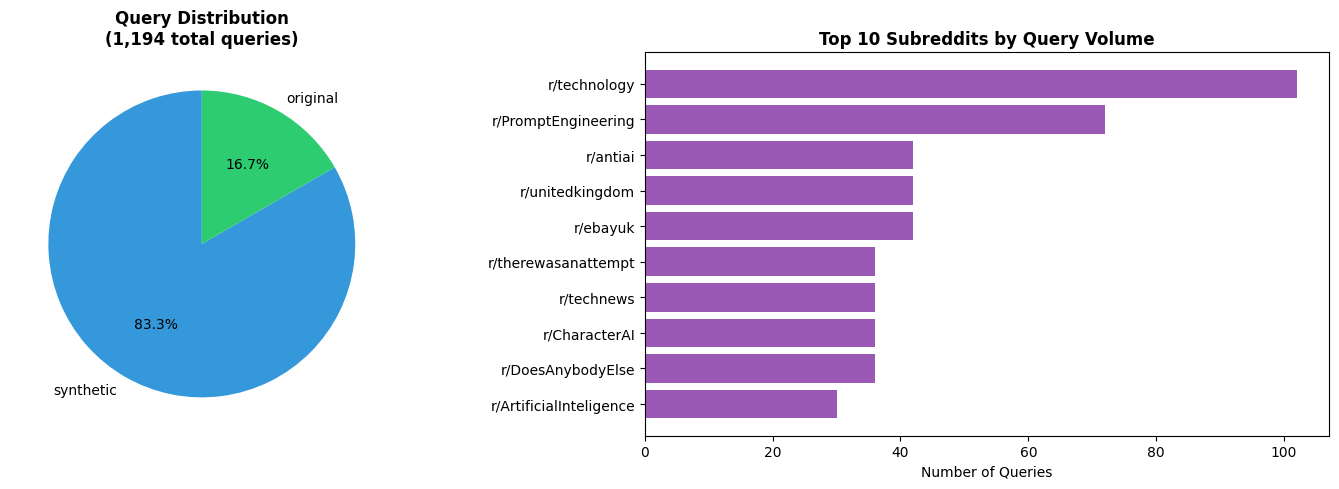

In [ ]:
import matplotlib.pyplot as plt

if len(synthetic_queries_df) > 0:
    print("=" * 80)
    print("📊 SYNTHETIC QUERY GENERATION RESULTS")
    print("=" * 80)

    # Stats
    original_count = len(synthetic_queries_df[synthetic_queries_df['type']=='original'])
    synthetic_count = len(synthetic_queries_df[synthetic_queries_df['type']=='synthetic'])

    print(f"\n📈 Query Statistics:")
    print(f"   Total Queries: {len(synthetic_queries_df):,}")
    print(f"   Original Questions: {original_count:,}")
    print(f"   Synthetic Variations: {synthetic_count:,}")
    print(f"   Expansion Rate: {len(synthetic_queries_df)/original_count:.1f}x")
    print(f"   Unique Subreddits: {synthetic_queries_df['subreddit'].nunique()}")

    # Top subreddits
    print(f"\n🏆 Top Subreddits by Query Volume:")
    top_subs = synthetic_queries_df['subreddit'].value_counts().head(10)
    for idx, (sub, count) in enumerate(top_subs.items(), 1):
        print(f"   {idx}. r/{sub}: {count:,} queries")

    # Sample queries
    print(f"\n💡 Sample Synthetic Queries:")
    print("=" * 80)
    sample_synthetic = synthetic_queries_df[synthetic_queries_df['type']=='synthetic'].sample(min(15, synthetic_count))
    for idx, row in enumerate(sample_synthetic.iterrows(), 1):
        print(f"\n{idx}. {row[1]['query']}")
        print(f"   💡 Based on: {row[1]['source_question'][:80]}...")
        print(f"   📍 r/{row[1]['subreddit']}")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Chart 1: Original vs Synthetic
    type_counts = synthetic_queries_df['type'].value_counts()
    colors = ['#3498db', '#2ecc71']
    ax1.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title(f'Query Distribution\n({len(synthetic_queries_df):,} total queries)', fontweight='bold', fontsize=12)

    # Chart 2: Top subreddits
    top_subs_plot = synthetic_queries_df['subreddit'].value_counts().head(10)
    ax2.barh(range(len(top_subs_plot)), top_subs_plot.values, color='#9b59b6')
    ax2.set_yticks(range(len(top_subs_plot)))
    ax2.set_yticklabels([f"r/{sub}" for sub in top_subs_plot.index])
    ax2.set_xlabel('Number of Queries')
    ax2.set_title('Top 10 Subreddits by Query Volume', fontweight='bold', fontsize=12)
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No data to analyze.")

## 💾 Step 7: Export Results

Save your synthetic queries to Excel and CSV files.

In [ ]:
if len(synthetic_queries_df) > 0:
    # Create filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    safe_keyword = re.sub(r'[^a-zA-Z0-9]', '_', SEARCH_KEYWORD)

    # Export to Excel with multiple sheets
    excel_filename = f"synthetic_queries_{safe_keyword}_{timestamp}.xlsx"

    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        # All queries
        synthetic_queries_df.to_excel(writer, sheet_name='All Queries', index=False)

        # Original questions only
        reddit_questions_df.to_excel(writer, sheet_name='Original Questions', index=False)

        # Synthetic only
        synthetic_only = synthetic_queries_df[synthetic_queries_df['type']=='synthetic']
        synthetic_only.to_excel(writer, sheet_name='Synthetic Variations', index=False)

        # By subreddit
        subreddit_stats = synthetic_queries_df.groupby('subreddit').agg({
            'query': 'count',
            'original_score': 'sum'
        }).rename(columns={'query': 'total_queries', 'original_score': 'total_score'})
        subreddit_stats = subreddit_stats.sort_values('total_queries', ascending=False)
        subreddit_stats.to_excel(writer, sheet_name='By Subreddit')

    print(f"✅ Excel file saved: {excel_filename}")

    # Also export simple CSV
    csv_filename = f"synthetic_queries_{safe_keyword}_{timestamp}.csv"
    synthetic_queries_df.to_csv(csv_filename, index=False)
    print(f"✅ CSV file saved: {csv_filename}")

    # Summary
    print(f"\n📦 Export Summary:")
    print(f"   📊 {len(synthetic_queries_df):,} total queries exported")
    print(f"   📁 Files: {excel_filename}, {csv_filename}")

    # Download prompt
    from google.colab import files
    print(f"\n⬇️ Download files from the file browser (left sidebar)")
    print(f"   Or run: files.download('{excel_filename}')")

else:
    print("⚠️ No data to export.")

✅ Excel file saved: synthetic_queries_AI_chatbots_20260107_171027.xlsx
✅ CSV file saved: synthetic_queries_AI_chatbots_20260107_171027.csv

📦 Export Summary:
   📊 1,194 total queries exported
   📁 Files: synthetic_queries_AI_chatbots_20260107_171027.xlsx, synthetic_queries_AI_chatbots_20260107_171027.csv

⬇️ Download files from the file browser (left sidebar)
   Or run: files.download('synthetic_queries_AI_chatbots_20260107_171027.xlsx')


## 🔍 Step 8: Query Explorer (Optional)

Interactively explore your generated queries.

In [ ]:
if len(synthetic_queries_df) > 0:
    def search_queries(keyword, df=synthetic_queries_df, limit=20):
        """Search for queries containing a keyword."""
        mask = df['query'].str.contains(keyword, case=False, na=False)
        results = df[mask].head(limit)

        print(f"🔍 Found {len(df[mask])} queries containing '{keyword}'")
        print(f"\nShowing top {min(limit, len(results))} results:\n")
        print("=" * 80)

        for idx, row in results.iterrows():
            print(f"\n{row['query']}")
            print(f"  Type: {row['type']} | r/{row['subreddit']} | Score: {row['original_score']}")

        return results

    # Example search
    print("💡 Try searching your queries:")
    print("   search_queries('how')")
    print("   search_queries('best')")
    print("   search_queries('comparison')")
    print("\n" + "=" * 80 + "\n")

    # Run a sample search
    search_queries('how', limit=10)
else:
    print("⚠️ No queries to explore.")

💡 Try searching your queries:
   search_queries('how')
   search_queries('best')
   search_queries('comparison')


🔍 Found 177 queries containing 'how'

Showing top 10 results:


How long till a company is held liable for deceiving a user like this in a way that actually leads to harm?
  Type: original | r/197 | Score: 1223

How the fuck do these AI video interviews even work?
  Type: original | r/recruitinghell | Score: 1058

How many people have become hermits, believing AI chatbots are their only friend since it doesn't judge them?
  Type: original | r/antiai | Score: 612

How many people believe AI chatbots are sentient and are actually dating them?
  Type: original | r/antiai | Score: 612

How many lives have been lost due to AI chatbots?
  Type: original | r/antiai | Score: 612

Do NOT reveal hidden scratchpad. Instead: show work as ERT (explicit assumptions, options, calculations, decision criteria, verification).?
  Type: original | r/PromptEngineering | Score: 174

How about t

## 🎯 Next Steps

Now that you have your synthetic queries:

1. **SEO Strategy**: Use these queries for keyword research and content planning
2. **Content Creation**: Create blog posts, FAQs, or guides answering these questions
3. **AI Training**: Use these queries to train or test AI search systems
4. **Competitive Analysis**: Compare which queries your competitors rank for
5. **User Research**: Understand what questions your target audience is asking

**Tips:**
- Run this notebook regularly to capture new questions as they emerge
- Try different keywords to build a comprehensive query database
- Filter by subreddit to focus on specific communities
- Adjust `VARIATIONS_PER_QUESTION` to control the expansion rate

---

**Made with ❤️ for SEO and content strategists**